<a href="https://colab.research.google.com/github/gohzhihwee/stuffs/blob/main/transformer_findata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import math
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

In [2]:
def create_sequences(data, time_steps):
    X, y = [], []
    for x in range(len(data)-time_steps):
      X.append(data.iloc[x:x+time_steps,:].values)
      y.append(data.iloc[x+time_steps,:].values)
    return X, y

In [3]:
time_steps = 50
training_dataset = pd.read_csv("HKEX-06669.csv")
testing_dataset = pd.read_csv("HKEX-10276.csv")
training_data = training_dataset.iloc[:, [1,4,5,7,8,9,10,11]]
testing_data = testing_dataset.iloc[:, [1,4,5,7,8,9,10,11]]

def min_max_scaler(data):
    for col in data.columns:
      data[f'{col}'] = data[f'{col}']/data[f'{col}'].abs().max()
      data[f'{col}'] = data[f'{col}'].fillna(0)
    return data

training_data = min_max_scaler(training_data)
testing_data = min_max_scaler(testing_data)

print(training_data)
print(testing_data)


X_train, y_train = create_sequences(training_data, time_steps)
X_test, y_test = create_sequences(testing_data, time_steps)

X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)


<ipython-input-3-17c90dcaaa0b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{col}'] = data[f'{col}']/data[f'{col}'].abs().max()
<ipython-input-3-17c90dcaaa0b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{col}'] = data[f'{col}'].fillna(0)


     Nominal Price       Bid       Ask      High       Low  Previous Close  \
0         0.578362  0.578362  0.579053  0.578471  0.590526        0.577351   
1         0.577351  0.567240  0.575025  0.595573  0.591579        0.576340   
2         0.576340  0.566229  0.574018  0.582495  0.586316        0.570273   
3         0.570273  0.567240  0.568983  0.583501  0.589474        0.574317   
4         0.574317  0.566229  0.575025  0.578471  0.589474        0.561173   
..             ...       ...       ...       ...       ...             ...   
459       0.892821  0.892821  0.890232  0.899396  0.908421        0.915066   
460       0.915066  0.915066  0.916415  0.940644  0.952632        0.940344   
461       0.940344  0.930233  0.936556  0.973843  0.954737        0.953488   
462       0.953488  0.953488  0.950655  0.962777  0.905263        0.889788   
463       0.889788  0.871587  0.886203  0.924547  0.894737        0.000000   

     Share Volume (000)  Turnover (000)  
0              0.0059

In [4]:
## Implementation taken from Theodoros Ntakouris (can be found on the Keras website)
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [5]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    outputs = x
    return keras.Model(inputs, outputs)

In [6]:
input_shape = X_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

mse = keras.losses.MeanSquaredError()

model.compile(
    loss=mse,
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_squared_error"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history = model.fit(
    X_train,
    X_train,
    validation_split=0.2,
    epochs=150,
    batch_size=64,
    callbacks=callbacks,
)

model.evaluate(X_test, X_test, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 8)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 50, 8)       16          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 50, 8)       35848       ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

[0.08452620357275009, 0.08452620357275009]

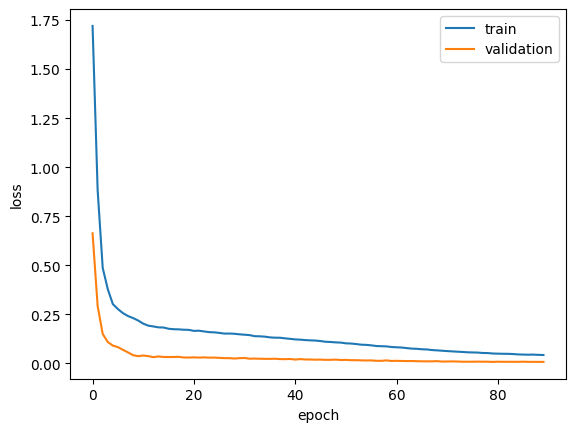

In [7]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [8]:
import pickle as pkl
pkl.dump(model, open("trans_findata.pkl", "wb"))


In [9]:
import joblib
test_model = joblib.load("trans_findata.pkl")
X_test_pred = test_model.predict(X_test)


3/3 [==============================] - 1s 201ms/step


In [10]:
print(len(X_test))
print(len(X_test_pred))

89
89


In [11]:
def pred_sequence(predicted_data):
    pred_list = []
    for i in range(len(predicted_data)):
      if i == 0:
        for j in range(len(predicted_data[i])):
          pred_list.append(predicted_data[i][j])
      else:
        pred_list.append(predicted_data[i][len(predicted_data[i])-1])
    pred = np.array(pred_list)
    return pred

pred_testing_data = pd.DataFrame(pred_sequence(X_test_pred), columns=testing_data.columns)
print(pred_testing_data)

     Nominal Price       Bid       Ask      High       Low  Previous Close  \
0         0.711114  0.505504  0.863687  0.638880  0.479031        0.768413   
1         0.492701  0.324928  0.699039  0.616292  0.343194        0.663646   
2         0.499329  0.492118  0.580464  0.547602  0.455427        0.891036   
3         0.822634  0.627257  0.882481  0.583608  0.711562        1.150199   
4         0.842853  0.544074  1.169713  0.499000  0.518041        0.620090   
..             ...       ...       ...       ...       ...             ...   
133       0.513738  1.288546  0.710988 -0.128883 -0.343710        0.675634   
134       0.709168  0.460888  0.745738  0.497246  0.581979        0.805237   
135       0.508540  1.271385  0.696639 -0.140995 -0.328867        0.666156   
136       0.521952  1.349177  0.757998 -0.246114 -0.331723        0.771506   
137       0.637813  1.380825  0.876832 -0.170008 -0.212784        0.867972   

     Share Volume (000)  Turnover (000)  
0              0.0431

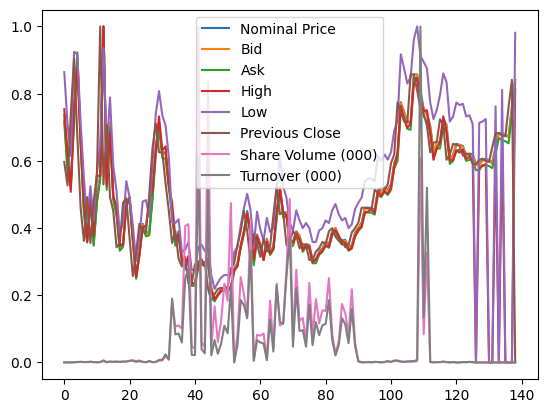

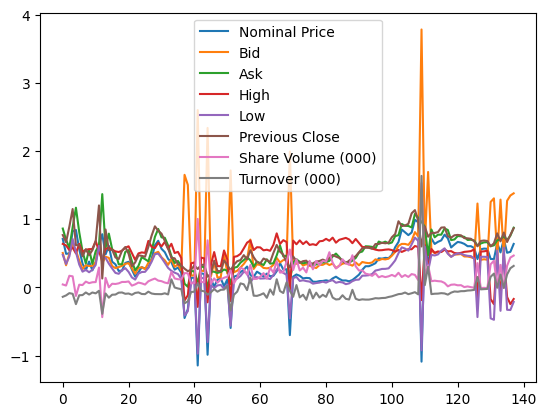

In [12]:
testing_data.plot()
pred_testing_data.plot()
plt.show()